# CompareFieldAbundanceMeasures

Australia's Terrestrial Ecosystem Research Network (TERN) hosts field survey data with vegetation cover estimates, which was used to validate their national vegetation cover mapping system. In this notebook we'll extract Bare-PV-NPV values from `earthlib` unmixing and from CSIRO's Australia-wide data, then comparing how well they map onto the field-estimated values.

In [103]:
# packages
import os

import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn import metrics
import elapid as ela
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [96]:
# set file and download paths
earthlib_dir = '/home/cba/src/earthlib'
data_dir = os.path.join(earthlib_dir, 'data')
field_data_path = os.path.join(data_dir, 'Vegetation-Communities-1.csv')
field_cover_path = os.path.join(data_dir, 'TERN-field-data.gpkg')
anno_cover_path = os.path.join(data_dir, 'TERN-field-data-annotated.gpkg')

# data processing parameters
year = 2010
months = range(1, 13)
gda94 = '+proj=longlat +ellps=GRS80 +no_defs +type=crs'

## Formatting the data

The TERN field data were collected over several years. Since we've already pulled data for each month over the year of 2010, we'll temporally align each plot to the corresponding month. This is a bit imprecise, as the data were collected over a four year period, but I hope that this will be sufficient for now.

In [ ]:
# FORGET SOME OF THE BELOW, GONNA HAVE TO CREATE A NEW FILE FROM `Vegetation-Communities_1`
# WHERE WE AVERAGE THE TRANSECT COVER VALUES USING THE PLOT ID AS A GROUPBY

In [23]:
df = pd.read_csv(field_data_path)
df.head()

/home/cba/src/miniconda3/envs/earthlib/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (0,7,8,12,14,15,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,38,39,40,41,42,43,44,45,46,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,65,66,67,68,70,71,72,73,74,75,76,77,79,80,81,82,83,84,85,86) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,TERN AEKOS Vegetation Community ID,TERN AEKOS Site ID,TERN AEKOS Site Visit ID,Custodian Site ID,Custodian Visit ID,Custodian Survey Name,Visit Date,Longitude (Decimal Degrees),Latitude (Decimal Degrees),Coordinate Reliability,...,Vegetation Structure Comment,Vegetation Structural Complexity Category,Dominant Life Form Category,Dominant Life Form Comment,Vegetation Age Structure Comment,Dominant Community Upper Stratum Comment,Dominant Community Lower Stratum Comment,Colour Comment,Method Name,Vegetation Community Comment
0,"TERN AEKOS-internal, unique identifier for the...","Unique, persistent URL identifier in TERN AEKO...",Unique identifier created in TERN AEKOS for a ...,Site identifier allocated by the custodian. No...,Visit identifier allocated by the custodian.,Custodian name of the ecological survey used t...,"Date (and time, if available) of the visit to ...",Longitudinal coordinate of the site in decimal...,Latitudinal coordinate of the site in decimal ...,Comments on the accuracy of the coordinate inf...,...,Vegetation structureï¿½isï¿½definedï¿½as the o...,Measure of the number of different structural ...,The most commonly occurring life form within a...,The most commonly occurring life form within a...,Age structure of a vegetation community.,Description or name of the vegetation communit...,Description or name of the vegetation communit...,The colour of a vegetation community.,The name of the method used to collect the veg...,Any additional information related to the vege...
1,1557197549126,aekos.org.au/collection/gov.au/abares/gcrs_NSW...,aekos.org.au/collection/gov.au/abares/gcrs_NSW...,NSW006,19-04-2011,Ground Cover Reference Sites Database of New S...,19-04-2011,142.32553,-32.44017,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cover Assessment Method,NaN
2,1557197549157,aekos.org.au/collection/gov.au/abares/gcrs_NSW...,aekos.org.au/collection/gov.au/abares/gcrs_NSW...,NSW006,19-04-2011,Ground Cover Reference Sites Database of New S...,19-04-2011,142.32553,-32.44017,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cover Assessment Method,NaN
3,1557197549187,aekos.org.au/collection/gov.au/abares/gcrs_NSW...,aekos.org.au/collection/gov.au/abares/gcrs_NSW...,NSW006,19-04-2011,Ground Cover Reference Sites Database of New S...,19-04-2011,142.32553,-32.44017,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cover Assessment Method,NaN
4,1557197549432,aekos.org.au/collection/gov.au/abares/gcrs_NSW...,aekos.org.au/collection/gov.au/abares/gcrs_NSW...,NSW006,19-04-2011,Ground Cover Reference Sites Database of New S...,19-04-2011,142.32553,-32.44017,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cover Assessment Method,NaN


In [92]:
# use the unique IDs for each plot to get the average veg cover value across all subplots
cover_field = 'Vegetation Cover Value'
id_field = 'Custodian Site ID'
date_field = 'Visit Date'
x_field = 'Longitude (Decimal Degrees)'
y_field = 'Latitude (Decimal Degrees)'
site_ids = list(df[id_field].unique())
site_ids.sort()
geoms = []
covers = []
months = []

# filter out a stupid header line first
for site_id in site_ids:
    site = df[df[id_field] == site_id]
    if len(site) <= 1:
        site_ids.remove(site_id)
        continue

for site_id in site_ids:
    site = df[df[id_field] == site_id]
    cover = site[cover_field].dropna().astype(float).mean()
    x = site[x_field].dropna().astype(float).mean()
    y = site[y_field].dropna().astype(float).mean()
    geom = Point(x, y)
    date = str(site[date_field].astype(str).mode()[0])
    day, month, year = date.split('-')
    
    covers.append(cover)
    geoms.append(geom)
    months.append(int(month))

# and merge into a single geodataframe
merged = gpd.GeoDataFrame(
    pd.DataFrame({
        'site_id': site_ids,
        'field_cover': covers,
        'month': months,
    }),
    geometry=geoms,
    crs=gda94,
)
merged.to_file(field_cover_path, driver='GPKG')

In [98]:
# create a list of subset points for each month and use that to pull raster data
band_names = ['csiro_bare', 'csiro_pv', 'csiro_npv', 'eli_bare', 'eli_pv', 'eli_npv']
monthly_dfs = []

for month in months:
    earthlib_path = os.path.join(data_dir, f"FC.v310.EARTHLIB.A2010.{month:02d}.aust.006.tif")
    csiro_path = os.path.join(data_dir, f"FC.v310.MCD43A4.A2010.{month:02d}.aust.006.tif")
    subset = merged[merged['month'] == month]
    
    anno = ela.raster_values_from_geoseries(
        subset.geometry,
        [csiro_path, earthlib_path],
        labels=band_names,
        drop_na=False,
    )
    
    anno['field_abundance'] = subset['field_cover']
    anno['month'] = subset['month']
    anno['site_id'] = subset['site_id']
    monthly_dfs.append(anno)
    
annotated = gpd.GeoDataFrame(pd.concat(monthly_dfs, ignore_index=True), crs=merged.crs)
annotated.to_file(anno_cover_path, driver='GPKG')

Raster:   0%|          | 0/2 [00:00<?, ?it/s]

Geometry:   0%|          | 0/26 [00:00<?, ?it/s]

Geometry:   0%|          | 0/26 [00:00<?, ?it/s]

Raster:   0%|          | 0/2 [00:00<?, ?it/s]

Geometry:   0%|          | 0/7 [00:00<?, ?it/s]

Geometry:   0%|          | 0/7 [00:00<?, ?it/s]

Raster:   0%|          | 0/2 [00:00<?, ?it/s]

Geometry:   0%|          | 0/8 [00:00<?, ?it/s]

Geometry:   0%|          | 0/8 [00:00<?, ?it/s]

Raster:   0%|          | 0/2 [00:00<?, ?it/s]

Geometry:   0%|          | 0/55 [00:00<?, ?it/s]

Geometry:   0%|          | 0/55 [00:00<?, ?it/s]

Raster:   0%|          | 0/2 [00:00<?, ?it/s]

Geometry:   0%|          | 0/58 [00:00<?, ?it/s]

Geometry:   0%|          | 0/58 [00:00<?, ?it/s]

Raster:   0%|          | 0/2 [00:00<?, ?it/s]

Geometry:   0%|          | 0/48 [00:00<?, ?it/s]

Geometry:   0%|          | 0/48 [00:00<?, ?it/s]

Raster:   0%|          | 0/2 [00:00<?, ?it/s]

Geometry:   0%|          | 0/63 [00:00<?, ?it/s]

Geometry:   0%|          | 0/63 [00:00<?, ?it/s]

Raster:   0%|          | 0/2 [00:00<?, ?it/s]

Geometry:   0%|          | 0/78 [00:00<?, ?it/s]

Geometry:   0%|          | 0/78 [00:00<?, ?it/s]

Raster:   0%|          | 0/2 [00:00<?, ?it/s]

Geometry:   0%|          | 0/61 [00:00<?, ?it/s]

Geometry:   0%|          | 0/61 [00:00<?, ?it/s]

Raster:   0%|          | 0/2 [00:00<?, ?it/s]

Geometry:   0%|          | 0/57 [00:00<?, ?it/s]

Geometry:   0%|          | 0/57 [00:00<?, ?it/s]

Raster:   0%|          | 0/2 [00:00<?, ?it/s]

Geometry:   0%|          | 0/15 [00:00<?, ?it/s]

Geometry:   0%|          | 0/15 [00:00<?, ?it/s]

Raster:   0%|          | 0/2 [00:00<?, ?it/s]

Geometry:   0%|          | 0/29 [00:00<?, ?it/s]

Geometry:   0%|          | 0/29 [00:00<?, ?it/s]

## Quantitative comparison

Now that we have co-alignment between the CSIRO field data, the CSIRO unmixing data, and `earthlib` unmxing data, we'll compare how each remote sensing dataset matches up with the field measurements using standard goodness-of-fit metrics.

In [134]:
# re-read the data if reloading the notebook
rerun = True
if rerun:
    annotated = gpd.read_file(anno_cover_path)

# filter nodata pixels prior to computing stats
csiro_valid = annotated['csiro_pv'] != 255
eli_valid = annotated['eli_pv'] != 255
eli_low = annotated['eli_pv'] < 90
valid = csiro_valid * eli_valid * eli_low
annotated = annotated[valid]

In [135]:
csiro_r2 = metrics.r2_score(annotated['field_abundance'], annotated['csiro_pv'])
csiro_rmse = np.sqrt(metrics.mean_squared_error(annotated['field_abundance'], annotated['csiro_pv']))
csiro_mae = metrics.mean_absolute_error(annotated['field_abundance'], annotated['csiro_pv'])
csiro_r = np.corrcoef(annotated['field_abundance'], annotated['csiro_pv'])[0][1]

eli_r2 = metrics.r2_score(annotated['field_abundance'], annotated['eli_pv'])
eli_rmse = np.sqrt(metrics.mean_squared_error(annotated['field_abundance'], annotated['eli_pv']))
eli_mae = metrics.mean_absolute_error(annotated['field_abundance'], annotated['eli_pv'])
eli_r = np.corrcoef(annotated['field_abundance'], annotated['eli_pv'])[0][1]

print(f"CSIRO | {csiro_r:0.2f} r | {csiro_mae:0.2f} mae | {csiro_r2:0.2f} r2 | {csiro_rmse:0.2f} rmse")
print(f"ELI   | {eli_r:0.2f} r | {eli_mae:0.2f} mae | {eli_r2:0.2f} r2 | {eli_rmse:0.2f} rmse")

CSIRO | 0.46 r | 11.45 mae | -4.99 r2 | 17.36 rmse
ELI   | 0.42 r | 10.29 mae | -4.32 r2 | 16.36 rmse


In [128]:
annotated['eli_pv'].mean()

17.206759443339962

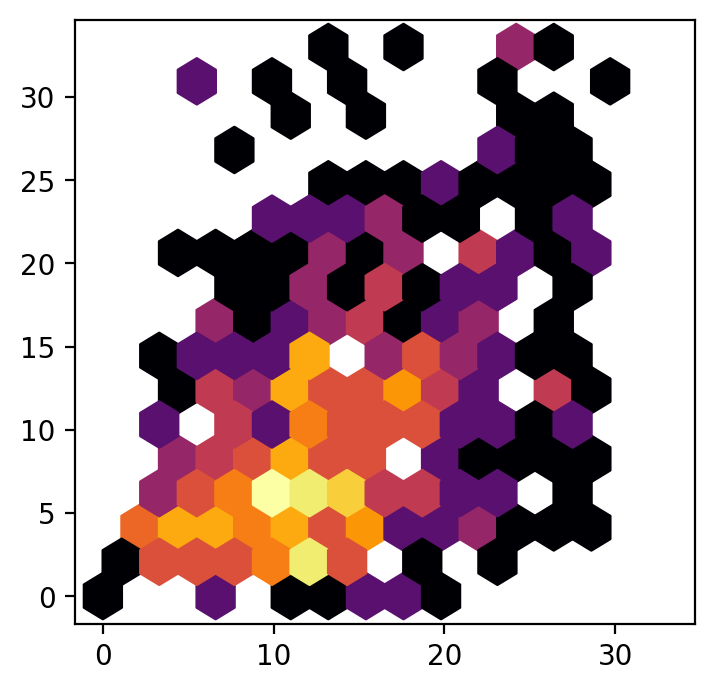

In [133]:
# plot 'em
figsize = (4, 4)
dpi = 200
extent = [0, 33, 0, 33]

plt.figure(figsize=figsize, dpi=dpi)
plt.hexbin(
    annotated['field_abundance'],
    annotated['eli_pv'],
    bins='log',
    cmap='inferno',
    mincnt=1,
    gridsize=15,
    extent=extent,
)